# 小胶质细胞亚群分析

新建并设置下基本配置

In [1]:
%reset -f
import yaml
# 定义一下接下来要处理的大群类型
# 这里不能使用w或w+否则会清空文件
with open(f"config.yaml", "r+", encoding='utf-8') as f:
    config = yaml.safe_load(f)

    # 清空文件内容
    f.truncate(0)
    f.seek(0)  # 确保指针在开头
    config["chosen_ct"] = chosen_celltype = "Microglia"
    config[chosen_celltype] = {}

    yaml.dump(config, f, default_flow_style=False, allow_unicode=True)

# 数据合并与提取

In [57]:
%reset -f
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import yaml
import os

os.getcwd()
sc.settings.verbosity = 3
# 定义一下接下来要处理的大群类型
with open(f"config.yaml", "r+", encoding='utf-8') as f:
    config = yaml.safe_load(f)
chosen_celltype = config["chosen_ct"]

adata = sc.read(f"data/{config['project_code']}_intergrate_after_qc.h5ad")

# 去除4hr的数据
mask = ~adata.obs["condition"].str.contains("4hr")
# 应用这个掩码来过滤样本
adata = adata[mask, :].copy()
# 备份原始数据
adata.raw = adata.copy()
display(adata)

# 筛选前去掉有问题的基因
# 把所有基因名取出来
genes = adata.var_names
# 构建布尔掩码，保留你想保留的基因
mask = ~genes.str.match("^Gm") \
    & ~genes.str.endswith("Rik") \
    & ~genes.str.match("^CT|^BC") \
    & ~genes.str.contains("Mir|Ftx|Tsix|Firre|Snhg|Kcnq1ot1", case=False) \
    & ~genes.str.contains("Eif2s3y|Ddx3y|Uty|Kdm5d", case=False) \
    & ~genes.str.contains("^Hb[ab]-[^\t\n]+.*$", case=False) \
    & ~genes.str.match("^Rps|^Rpl", case=False) \
    & ~genes.str.match("^mt-", case=False)
# 应用这个掩码来过滤基因
adata = adata[:, mask].copy()

AnnData object with n_obs × n_vars = 72332 × 16422
    obs: 'sample', 'batch', 'condition', 'major_celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score'

In [58]:
import pandas as pd
import scanpy as sc

# 假设 adata 是你的 AnnData 对象
# 确认 'sample' 列存在
print(adata.obs.columns)  # 确认 'sample' 列存在

# 手动输入表格数据（根据你的数据）
data = {
    "Sample": [
        "GSM4227433", "GSM4227434", "GSM4227435", "GSM4227436", "GSM4227437", "GSM4227438",
        "GSM4227439", "GSM4227440", "GSM4227441", "GSM4227442", "GSM4227443", "GSM7104632",
        "GSM7104633", "GSM7104634", "GSM7104635", "GSM7437217", "GSM7437218", "GSM7437219",
        "GSM7437220"
    ],
    "time": [
        "4hr", "4hr", "1d", "1d", "3d", "3d", "7d", "7d", "unknown", "unknown", "unknown", 
        "1d", "3d", "7d", "7d", 
        "unknown", "1d", "3d", "7d"
    ],
    "group": [
        "sham", "MCAO", "sham", "MCAO", "sham", "MCAO", "sham", "MCAO", "sham", "sham",
        "sham", "MCAO", "MCAO", "MCAO", "sham", "sham", "MCAO", "MCAO", "MCAO"
    ]
}

# 创建 DataFrame
df_mapping = pd.DataFrame(data)

# 确保 'sample' 列值一致（去除空格，转换为大写）
adata.obs['sample'] = adata.obs['sample'].str.strip().str.upper()
df_mapping['Sample'] = df_mapping['Sample'].str.strip().str.upper()

# 创建映射字典
sample_to_time = dict(zip(df_mapping['Sample'], df_mapping['time']))
sample_to_group = dict(zip(df_mapping['Sample'], df_mapping['group']))

# 使用 map 映射 time 和 group
adata.obs['time'] = adata.obs['sample'].map(sample_to_time)
adata.obs['group'] = adata.obs['sample'].map(sample_to_group)

# 可选：将新列转换为 category 类型（优化内存，适合 CellPhoneDB）
adata.obs['time'] = adata.obs['time'].astype('category')
adata.obs['group'] = adata.obs['group'].astype('category')

adata.obs['condition'] = adata.obs.apply(
    lambda x: 'sham' if x['group'] == 'sham' else f'MCAO_{x["time"].split("_")[-1]}' if 'MCAO' in x['group'] else x['group'],
    axis=1
)

Index(['sample', 'batch', 'condition', 'major_celltype', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_20_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score'],
      dtype='object')


In [59]:
# 提取指定类型对应的大类细胞
adata_selected = adata[adata.obs.loc[:,"major_celltype"]==config["chosen_ct"]]
# 保存
adata_selected.write(f"data/{config['project_code']}_{config["chosen_ct"]}_intergrate_after_qc.h5ad")
# 展示细胞概况
adata_selected.obs.columns

Index(['sample', 'batch', 'condition', 'major_celltype', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_20_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score',
       'time', 'group'],
      dtype='object')

# 亚群聚类

'/Volumes/MacPassport/project/bioinformatics_project/sn_sc_intergration'

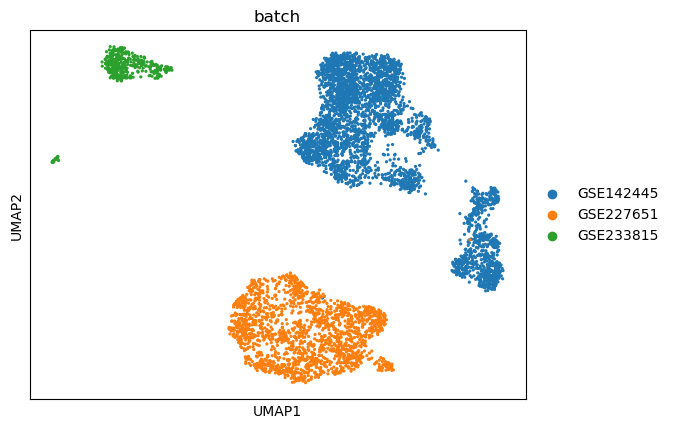

AnnData object with n_obs × n_vars = 5625 × 3000
    obs: 'sample', 'batch', 'condition', 'major_celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'time', 'group'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [13]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os

display(os.getcwd())
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3
chosen_celltype = config["chosen_ct"]

adata = sc.read(f"data/{config['project_code']}_{chosen_celltype}_intergrate_after_qc.h5ad")

# 归一化
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
# 筛选高可变基因
# batch_key:按样本筛选高变基因
sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key="sample")
# highly_variable_nbatches：哪一个样本的batch中出现的hvg，0代表非hvg
adata = adata[:, adata.var.highly_variable]
# 输出高变基因供查找
pd.Series(adata.var.index).to_csv(f"result/{chosen_celltype}_hvg.csv")

sc.tl.pca(adata, n_comps=30)
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)
sc.pl.umap(adata, color="batch")
adata

2025-08-02 18:42:16,851 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-02 18:42:17,920 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-02 18:42:17,974 - harmonypy - INFO - Iteration 1 of 20
2025-08-02 18:42:18,638 - harmonypy - INFO - Iteration 2 of 20
2025-08-02 18:42:19,274 - harmonypy - INFO - Converged after 2 iterations


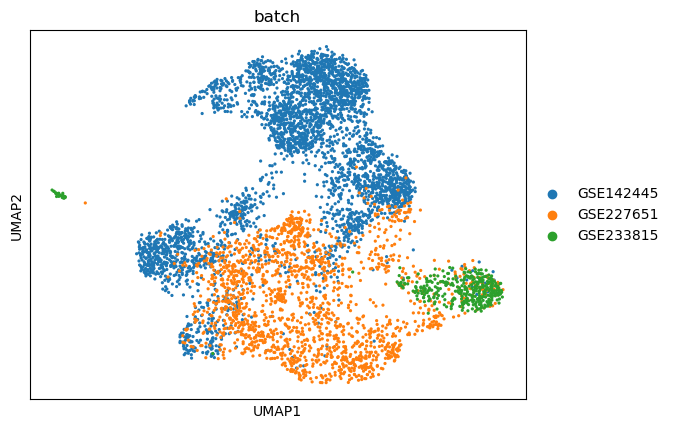

AnnData object with n_obs × n_vars = 5625 × 3000
    obs: 'sample', 'batch', 'condition', 'major_celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'time', 'group', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res1', 'leiden_res1.5'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors', 'tsne', 'leiden_res0.25', 'leiden_res0.5', 'leiden_res1', 'leiden_res1.5'
    obsm: 'X_pca', 'X_umap', 'X_harmony', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [14]:
import scanpy.external as sce

# harmony
sc.tl.pca(adata, n_comps=50)
# 包的作者停止维护了，如果不能安装，强制安装即可
# pip install harmonypy (--no-deps)
sce.pp.harmony_integrate(adata=adata, key='batch',
                         basis='X_pca',
                         max_iter_harmony = 20,
                         theta = None,
                         lamb = None,
                         sigma = 0.1, 
                         nclust = None,
                         tau = 0,
                         block_size = 0.05, 
                         max_iter_kmeans = 20,
                         epsilon_cluster = 1e-5,
                         epsilon_harmony = 1e-4, 
                         adjusted_basis='X_harmony')
# umap
sc.pp.neighbors(adata=adata, use_rep='X_harmony')
sc.tl.umap(adata=adata)
# tsne
sc.tl.tsne(adata=adata, use_rep='X_harmony')

for res in [0.25, 0.5, 1, 1.5]:
    sc.tl.leiden(adata, flavor="leidenalg", directed=False, resolution=res, key_added=f"leiden_res{res}")

sc.pl.umap(adata, color="batch")
adata

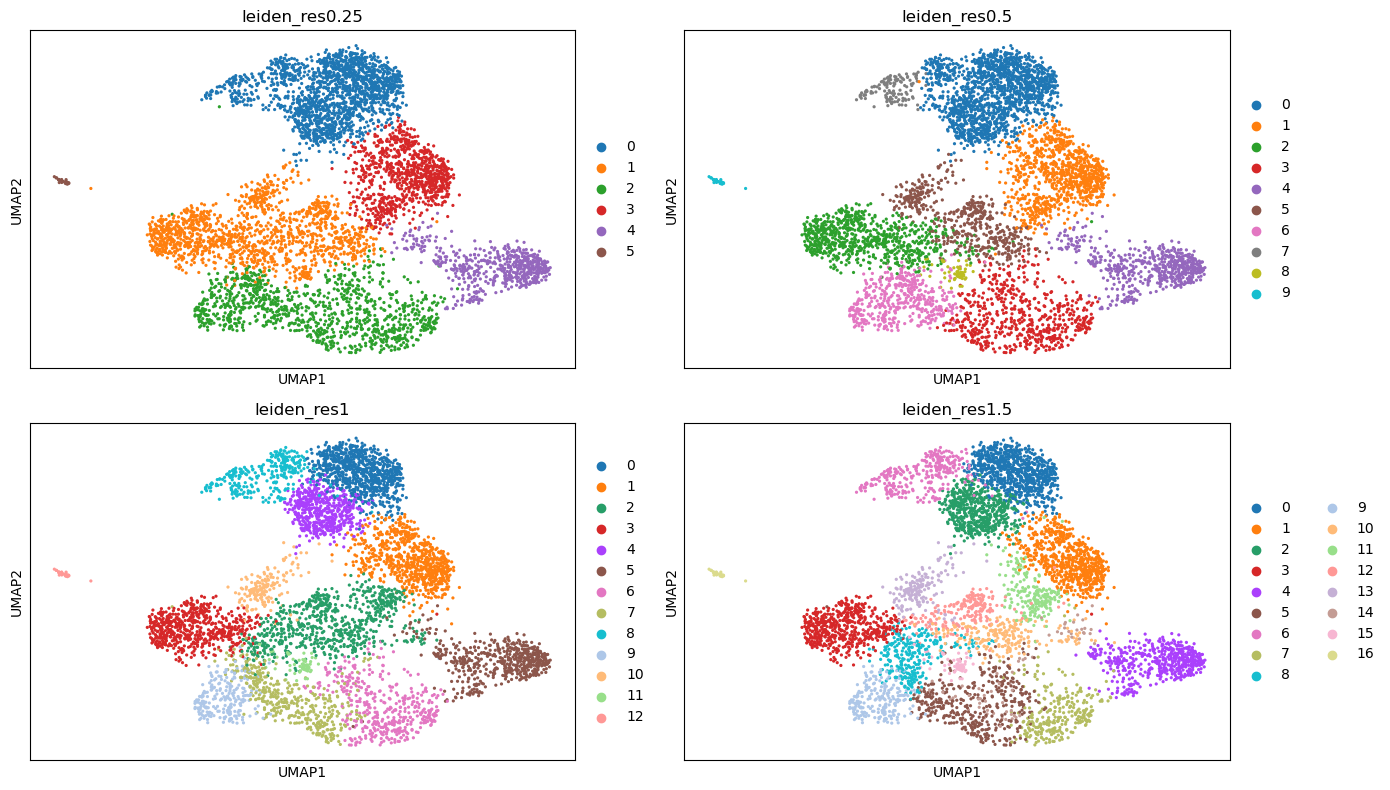

In [15]:
color_list = ["leiden_res0.25", "leiden_res0.5",  "leiden_res1",  "leiden_res1.5"]

# 指定网格布局
n_rows = 2
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 7, n_rows * 4))

# 将 axes 转换为一维数组以便迭代（如果行列数 > 1）
axes_flat = axes.flatten()

# 为每个 color 绘制 UMAP 图
for i, color in enumerate(color_list):
    if i < n_rows * n_cols:  # 确保不超出子图数量
        ax = axes_flat[i]
        sc.pl.umap(adata, color=color, ax=ax, show=False, title=color)
    else:
        break  # 如果 color_list 比子图多，停止绘制

# 隐藏多余的子图（如果 color_list 不足以填满网格）
for i in range(len(color_list), n_rows * n_cols):
    axes_flat[i].axis("off")

# 调整布局以避免重叠
plt.tight_layout()
plt.savefig(f"figures/{chosen_celltype}_leiden_result.pdf")

In [16]:
# 选择聚类结果
config[chosen_celltype]["cluster_key_chosen"] = "leiden_res0.5"
# 记录至配置文件
with open('config.yaml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False, allow_unicode=True)

# 亚群命名
adata.obs.loc[:, "sub_celltype"] = ("MG" + adata.obs.loc[:, config[chosen_celltype]["cluster_key_chosen"]].astype(str)).astype('category')
# 找出所有包含“leiden”的列
leiden_columns = [col for col in adata.obs.columns if 'leiden' in col.lower()]
# 删除这些列
adata.obs = adata.obs.drop(columns=leiden_columns)
# 数据保存
adata.write(f"data/{config['project_code']}_{chosen_celltype}_cluster.h5ad")

# 亚群间细胞通讯
使用Jupyter环境cqdb

In [1]:
%reset -f
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import yaml,os

display(os.getcwd())
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3
chosen_celltype = config["chosen_ct"]
import warnings
warnings.filterwarnings('ignore')

adata = sc.read(f"data/{config['project_code']}_{chosen_celltype}_cluster.h5ad")

from IPython.display import HTML, display
from cellphonedb.utils import db_releases_utils
display(HTML(db_releases_utils.get_remote_database_versions_html()['db_releases_html_table']))

'/Volumes/MacPassport/project/bioinformatics_project/sn_sc_intergration'

In [2]:
# 下载数据库
from cellphonedb.utils import db_utils
import os

# 数据集版本
cpdb_version = 'v5.0.0'
# 定义下载位置
cpdb_target_dir = os.path.join('/Users/william_han/bioinfo_db/cpdb_db/', cpdb_version)
# 创建路径并下载
if not os.path.exists("/Users/william_han/bioinfo_db/cpdb_db/v5.0.0"):
    os.makedirs(cpdb_target_dir, exist_ok=True)
    db_utils.download_database(cpdb_target_dir, cpdb_version)
else:
    print("File Exists!")

File Exists!


1. 映射的时候人类基因可能对应多个小鼠基因：merge完后再求平均
2. 单个小鼠基因也可能对应多个人类基因：复制行

In [3]:
from scipy.sparse import csr_matrix

# 1. 读同源表（保持原始列名）
biomart_path = "/Users/william_han/bioinfo_db/mart_export.txt"
mmu2hsa = pd.read_csv(biomart_path, sep="\t") \
    .loc[:, ["Human gene name", "Gene name"]] \
    .drop_duplicates() \
    .dropna()

# 统一列名
mmu2hsa.columns = ["hsa_gene_name", "mmu_gene_name"]

# 2. 把小鼠 var.index 变成 DataFrame 并映射
var_df = adata.var.reset_index(drop=False) \
    .rename(columns={"index": "mmu_gene_name"}) \
    .merge(mmu2hsa, on="mmu_gene_name", how="left")

# 3. 构建表达矩阵（稀疏或稠密均可）
expr = adata.X.T
if hasattr(expr, "toarray"):            # 稀疏矩阵转稠密
    expr = expr.toarray()
mmu_expr = pd.DataFrame(expr, columns=adata.obs_names, index=adata.var_names)
hsa_expr = mmu_expr.reset_index(drop=False) \
    .rename(columns={"index": "mmu_gene_name"}) \
    .merge(mmu2hsa, on="mmu_gene_name", how="left") \
    .drop("mmu_gene_name", axis=1) \
    .groupby("hsa_gene_name").mean() \
    .T

# 构建新的 AnnData
adata_hsa = sc.AnnData(
    X=csr_matrix(hsa_expr.values),
    obs=adata.obs.copy(),
    var=pd.DataFrame(index=hsa_expr.columns)
)
adata_hsa.write(f"data/cpdb/log2count_{chosen_celltype}.h5ad")

# 根据新数据构建metadata
adata_hsa.obs.loc[:, ["sub_celltype"]].reset_index(drop=False).to_csv(f"data/cpdb/metadata_{chosen_celltype}.tsv", sep="\t", index=None)

大多数输出文件都包含以下公共列：
- id_cp_interaction：CellphoneDB 为数据库中每条互作关系分配的唯一标识符
- interacting_pair：以“|”分隔的互作分子对名称
- partner A / partner B：互作分子 A 或 B 的标识符。格式可能是：
    - UniProt ID（前缀 simple:）
    - 复合体（前缀 complex:）
- gene A / gene B：互作分子 A 或 B 的基因标识符，具体取决于用户输入列表
- secreted：若其中任一分子为分泌蛋白，则为 True
- receptor A / receptor B：若分子 A 或 B 在数据库中被注释为受体，则为 True
- annotation_strategy：
    - curated：由 CellphoneDB 团队人工注释。
    - 其他：数据来源数据库名称。
- is_integrin：若任一分子为整合素（integrin），则为 True
- directionality：描述互作的方向性以及互作分子的特性
- classification：互作分子所属通路或功能分类

Means 相关字段：
- means：所有互作分子对的均值
    - 计算方式：对每一对细胞类型，先分别计算分子 A 和分子 B 在该细胞类型中的平均表达量，再取这两个平均值的算术平均作为最终值
    - 若任一分子的平均表达量为 0，则最终均值直接设为 0

In [4]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

cpdb_file_path = "/Users/william_han/bioinfo_db/cpdb_db/v5.0.0/cellphonedb.zip"
meta_data = f"data/cpdb/metadata_{chosen_celltype}.tsv"
counts_data = f"data/cpdb/log2count_{chosen_celltype}.h5ad"
# meta_data = "/Users/william_han/Downloads/test_counts.txt"
# counts_data = "/Users/william_han/Downloads/test_meta.txt"
out_path = f'result/cpdb_{chosen_celltype}_method2_withScore'

# 下面这一部分是为了适配jupyter notebook 设置多线程的参数
import sys
from types import ModuleType

if not hasattr(sys.modules['__main__'], '__spec__'):
    sys.modules['__main__'].__spec__ = ModuleType('__main__').__spec__

cpdb_results = cpdb_statistical_analysis_method.call(
         cpdb_file_path = cpdb_file_path,
         meta_file_path = meta_data,
         counts_file_path = counts_data,
         counts_data = 'hgnc_symbol',
         output_path = out_path)

Reading user files...
The following user files were loaded successfully:
data/cpdb/log2count_Microglia.h5ad
data/cpdb/metadata_Microglia.tsv
[ ][CORE][02/08/25-18:43:51][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:-1 Threads:4 Precision:3
[ ][CORE][02/08/25-18:43:51][INFO] Running Real Analysis
[ ][CORE][02/08/25-18:43:51][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [00:06<00:00, 152.47it/s]

[ ][CORE][02/08/25-18:43:58][INFO] Building Pvalues result
[ ][CORE][02/08/25-18:43:58][INFO] Building results
Saved deconvoluted to result/cpdb_Microglia_method2_withScore/statistical_analysis_deconvoluted_08_02_2025_184358.txt
Saved deconvoluted_percents to result/cpdb_Microglia_method2_withScore/statistical_analysis_deconvoluted_percents_08_02_2025_184358.txt
Saved means to result/cpdb_Microglia_method2_withScore/statistical_analysis_means_08_02_2025_184358.txt
Saved pvalues to result/cpdb_Microglia_method2_withScore/statistical_analysis_pvalues_08_02_2025_184358.txt
Saved significant_means to result/cpdb_Microglia_method2_withScore/statistical_analysis_significant_means_08_02_2025_184358.txt


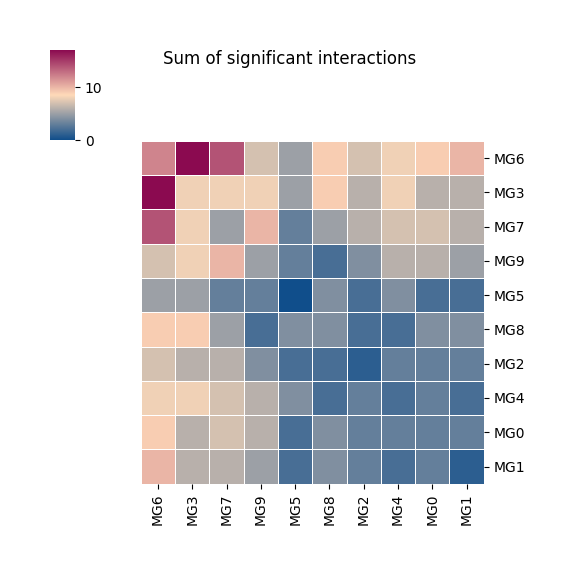

In [5]:
import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy

kpy.plot_cpdb_heatmap(pvals = cpdb_results['pvalues'],
                      degs_analysis = False,
                      figsize = (5, 5),
                      title = "Sum of significant interactions")

绘图可见https://www.jianshu.com/p/b3d26ac51c5a

# 小胶质亚群间拟时序分析

In [1]:
%reset -f
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import yaml,os

display(os.getcwd())
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3
chosen_celltype = "Microglia"
import warnings
warnings.filterwarnings('ignore')

adata = sc.read(f"data/{config['project_code']}_{chosen_celltype}_cluster.h5ad")
# 去掉第5群,这一群分化情况有点过于鹤立鸡群
adata = adata[adata.obs.loc[:, "sub_celltype"] != 'MG9']

'/Volumes/MacPassport/project/bioinformatics_project/sn_sc_intergration'

<Axes: >

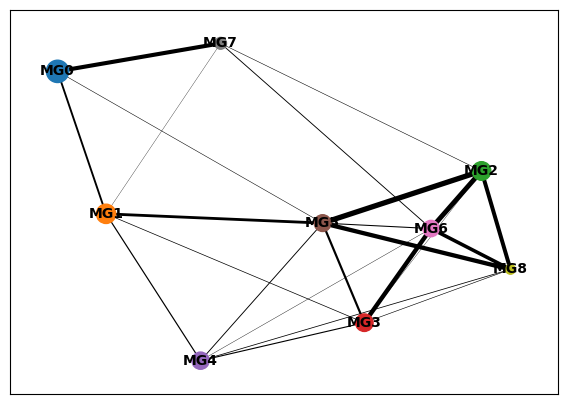

In [2]:
sc.tl.paga(adata, groups="sub_celltype")
sc.pl.paga(adata, threshold=0.03, show=False)

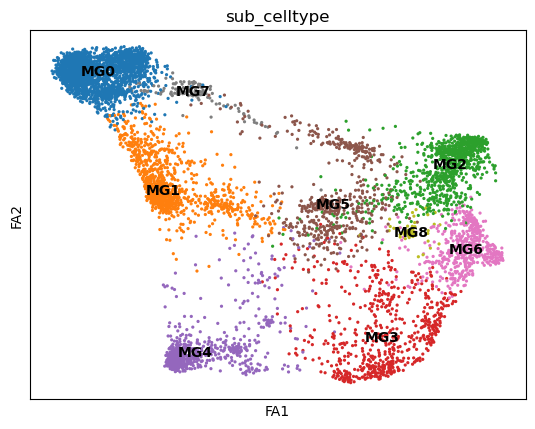

In [3]:
#利用PAGA重新计算细胞之间的距离
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.draw_graph(adata, color="sub_celltype", cmap="Set2", legend_loc='on data')

Trying to run `tl.dpt` without prior call of `tl.diffmap`. Falling back to `tl.diffmap` with default parameters.
saving figure to file figures/draw_graph_fa/paga_peudotime_Microglia.pdf


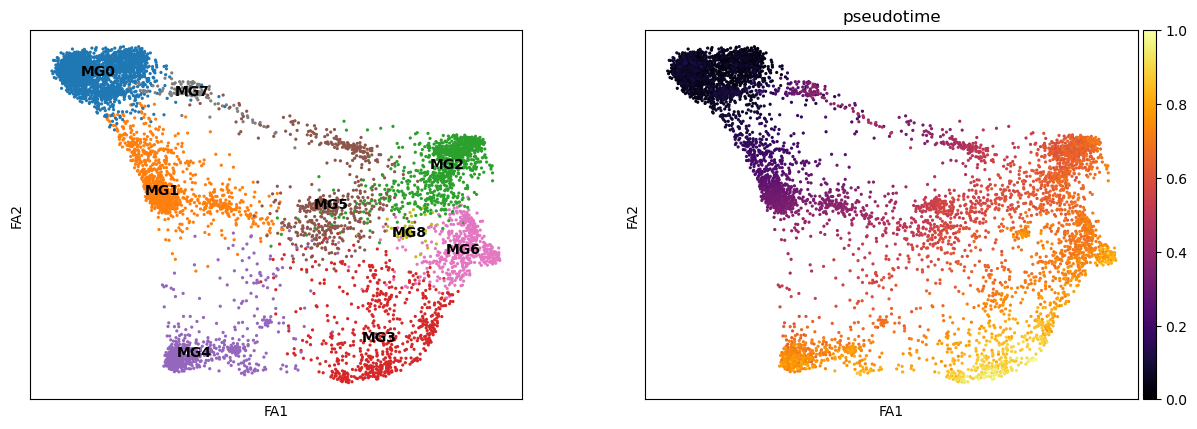

In [4]:
import numpy as np

adata.uns['iroot'] = np.flatnonzero(adata.obs["sub_celltype"]  == 'MG0')[0] ##假设分化起点为B cells,当然自己分析的时候需要根据数据实际情况选择分化起点
sc.tl.dpt(adata)
os.makedirs("figures/draw_graph_fa", exist_ok=True)
sc.pl.draw_graph(adata, color=["sub_celltype", 'dpt_pseudotime'], legend_loc='on data', title = ['','pseudotime'], cmap="inferno", frameon=True, 
                 save=f"/paga_peudotime_{chosen_celltype}.pdf")

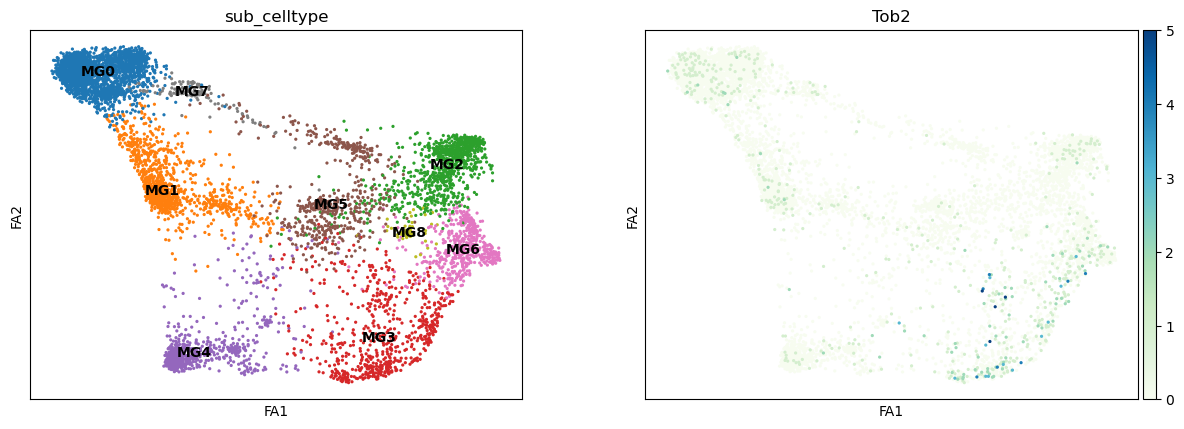

In [5]:
sc.pl.draw_graph(adata, color=["sub_celltype", 'Tob2'], legend_loc='on data', cmap="GnBu", frameon=True)

# 亚群功能分析

## 差异分析

In [6]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os

display(os.getcwd())
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3
chosen_celltype = "Microglia"

import warnings
warnings.filterwarnings('ignore')

adata = sc.read(f"data/{config['project_code']}_{chosen_celltype}_cluster.h5ad")
# 去掉第9群,这一群分化情况有点过于鹤立鸡群
adata = adata[adata.obs.loc[:, "sub_celltype"] != 'MG9']

'/Volumes/MacPassport/project/bioinformatics_project/sn_sc_intergration'

In [7]:
# 亚群差异分析
adata_rank = sc.tl.rank_genes_groups(adata, 
                                     groupby="sub_celltype", 
                                     groups="all",
                                     reference="rest",
                                     method="wilcoxon", 
                                     use_raw=False, copy=True, pts=True)
# 结果存储在adata_rank.uns['rank_genes_groups']['names']
# # 可视化分群结果
# sc.pl.rank_genes_groups(adata_rank, n_genes=20, sharey=False)

os.makedirs(f"result/deg_by_{chosen_celltype}_subcluster", exist_ok=True)

for celltype in adata_rank.uns['rank_genes_groups']["names"].dtype.names:
    res = pd.DataFrame({'names': adata_rank.uns['rank_genes_groups']["names"][celltype], 
                        'scores': adata_rank.uns['rank_genes_groups']["scores"][celltype],
                        'pvals': adata_rank.uns['rank_genes_groups']["pvals"][celltype],
                        'pvals_adj': adata_rank.uns['rank_genes_groups']["pvals_adj"][celltype],
                        'log2foldchanges': adata_rank.uns['rank_genes_groups']["logfoldchanges"][celltype],
                        'diff.pct': adata_rank.uns['rank_genes_groups']["pts"][celltype] - adata_rank.uns['rank_genes_groups']["pts_rest"][celltype]})
    res = res.sort_values(
        by=["diff.pct", "log2foldchanges", "pvals_adj"],
        key=lambda x: x.abs() if x.name == "log2foldchanges" else x,
        ascending=[False, False, True]
    )
    # res = res.sort_values(by=["log2foldchanges","pvals"], ascending=[False,True])
    mask = (res['log2foldchanges'].abs() > 1) & (res['pvals'] < 0.1)
    res.loc[mask, :].to_csv(f"result/deg_by_{chosen_celltype}_subcluster/deg_of_{celltype}.tsv", index=None, sep="\t")
    res.sort_values(by="log2foldchanges", ascending=False).loc[mask, :].head(100) \
        .to_csv(f"result/deg_by_{chosen_celltype}_subcluster/top100_deg_of_{celltype}.tsv", index=None, sep="\t")

No genes found for group MG1
saving figure to file figures/dotplot_Microglia_subcluster/rank_genes_groups_dotplot.pdf


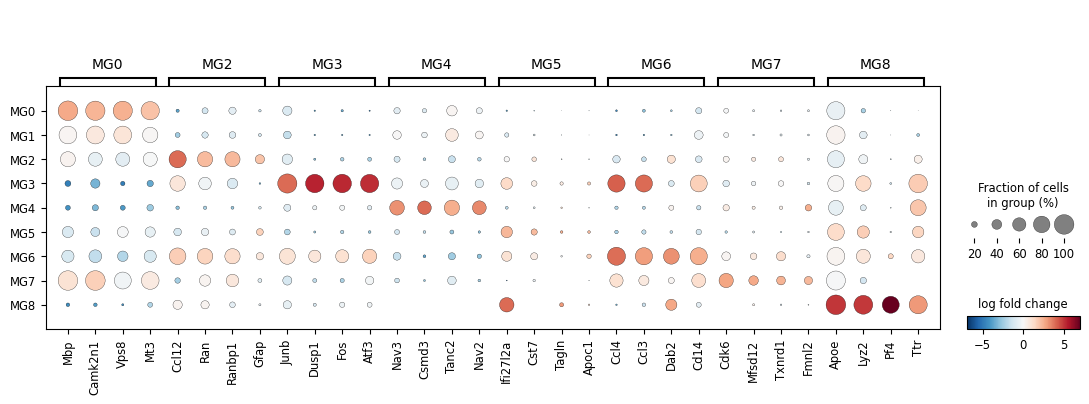

In [8]:
os.makedirs(f"figures/dotplot_{chosen_celltype}_subcluster", exist_ok=True)
# 绘制圆点热图，指定排序后的分群
sc.pl.rank_genes_groups_dotplot(
    adata_rank,
    n_genes=4,                           # 每群显示 top 4 基因
    values_to_plot="logfoldchanges",     # 显示 log fold change
    min_logfoldchange=2,                 # 最小 log fold change 阈值
    vmax=7,                              # 颜色最大值
    vmin=-7,                             # 颜色最小值
    cmap="RdBu_r",                       # 颜色方案
    dendrogram=False,                    # 这一项不加的话默认的纵轴排序顺序是按聚类结果远近排序的
    save=f"{chosen_celltype}_subcluster/rank_genes_groups_dotplot.pdf" # 前面有figures/dotplot_前缀
)

### 表达差异比例火山图

In [9]:
from adjustText import adjust_text

result = adata_rank.uns['rank_genes_groups']

volcanno_path = f"figures/Volcano/{chosen_celltype}_subcluster"
os.makedirs(volcanno_path, exist_ok=True)

for group in result['names'].dtype.names:
    genes = result['names'][group]   # 提取所有基因（以第一个群为例）
    logfoldchanges = result['logfoldchanges'][group]  # log2 fold change
    pvals_adj = result['pvals_adj'][group]            # 调整后的 p 值

    # 2. 计算 .pct 轴数据（假设为 pct[1] - pct[0]，表示两群间差异百分比）
    # 这里简化为 pct 数据，实际可根据你的数据调整
    pct_diff = result['pts'][group] - result['pts_rest'][group]   # 假设两群比较

    # 3. 确定上下调基因（基于 logfoldchanges 和 p 值）
    # 假设 logfoldchange > 0.5 且 p_adj < 0.05 为上调，< -0.5 为下调
    logfoldchanges_thres = 1
    pvals_adj_thres = 0.05
    upregulated = (logfoldchanges > logfoldchanges_thres) & (pvals_adj < pvals_adj_thres)
    downregulated = (logfoldchanges < -logfoldchanges_thres) & (pvals_adj < pvals_adj_thres)
    nonregulated = ~(upregulated | downregulated)

    # 4. 绘制火山图
    plt.figure(figsize=(8, 6))
    plt.scatter(pct_diff[nonregulated], logfoldchanges[nonregulated], c='gray', s=10, label='non')
    plt.scatter(pct_diff[upregulated], logfoldchanges[upregulated], c='red', s=10, label='up')
    plt.scatter(pct_diff[downregulated], logfoldchanges[downregulated], c='blue', s=10, label='down')

    # 6. 添加标签和指示线
    texts = []
    # 按 pct_diff 排序，筛选 log2FC > log fold changes阈值 的前 5 个
    indices = pct_diff.argsort()[-5:][::-1]  # 取绝对值最大的 5 个索引
    positive_indices = [i for i in indices if logfoldchanges[i] > logfoldchanges_thres]  # 筛选 log2FC > 0
    top_genes = genes[positive_indices[:5]]  # 取前 5 个（如果不足 5 个则取所有）

    for i, gene in enumerate(top_genes):
        idx = np.where(genes == gene)[0][0]
        text = plt.text(pct_diff[idx], logfoldchanges[idx], gene, fontsize=8)
        texts.append(text)

    # 调整文本位置以避免重叠
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

    # 7. 添加标签和显著基因标注
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.xlabel('Difference of expression percentage')
    plt.ylabel('Log2FC')
    plt.title('Volcano Plot of Differentially Expressed Genes')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f"{volcanno_path}/pct_deg_{group}.pdf")
    plt.close()

## 通路富集分析

|Dataset|Sample|上传时标签|time|group|
|-------|---------|--------|----|-----|
|GSE142445|GSM4227433|4hr_contralateral|4hr|sham|
|GSE142445|GSM4227434|4hr_ipsilateral|4hr|MCAO|
|GSE142445|GSM4227435|1d_contralateral|1d|sham|
|GSE142445|GSM4227436|1d_ipsilateral|1d|MCAO|
|GSE142445|GSM4227437|3d_contralateral|3d|sham|
|GSE142445|GSM4227438|3d_ipsilateral|3d|MCAO|
|GSE142445|GSM4227439|7d_contralateral|7d|sham|
|GSE142445|GSM4227440|7d_ipsilateral|7d|MCAO|
|GSE142445|GSM4227441|uninjured_1|unknown|sham|
|GSE142445|GSM4227442|uninjured_2|unknown|sham|
|GSE142445|GSM4227443|uninjured_3|unknown|sham|
|GSE227651|GSM7104632|tMCAO_day 1|1d|MCAO|
|GSE227651|GSM7104633|tMCAO_day 3|3d|MCAO|
|GSE227651|GSM7104634|tMCAO_day 7|7d|MCAO|
|GSE227651|GSM7104635|sham_day 7|7d|sham|
|GSE233815|GSM7437217|sham|unknown|sham|
|GSE233815|GSM7437218|pMCAO_D1|1d|MCAO|
|GSE233815|GSM7437219|pMCAO_D3|3d|MCAO|
|GSE233815|GSM7437220|pMCAO_D7|7d|MCAO|

看一下比例

In [1]:
%reset -f
import scanpy as sc
import matplotlib.pyplot as plt
import yaml, os
import pandas as pd
import warnings
import gseapy as gp

warnings.filterwarnings('ignore')
display(os.getcwd())
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3
chosen_celltype = "Microglia"
# 加载数据
adata = sc.read(f"data/{config['project_code']}_{chosen_celltype}_cluster.h5ad")
# 去掉第5群,这一群分化情况有点过于鹤立鸡群
adata = adata[adata.obs.loc[:, "sub_celltype"] != 'MG9']
# 所有可用数据库名称
database_library = gp.get_library_name()
# 指定KEGG和GO基因集
gene_sets = ['KEGG_2019_Mouse', 
             'MSigDB_Hallmark_2020',
             'GO_Biological_Process_2025', 
             'GO_Cellular_Component_2025', 
             'GO_Molecular_Function_2025']

'/Volumes/MacPassport/project/bioinformatics_project/sn_sc_intergration'

### GSEA分析

In [2]:
from tqdm import tqdm
for ct in tqdm(adata.obs.loc[:, "sub_celltype"].drop_duplicates()):
    adata_selected = adata[adata.obs.sub_celltype == ct].copy()
    res = gp.gsea(data=adata_selected.to_df().T, # row -> genes, column-> samples
                  gene_sets=gene_sets,
                  cls=adata_selected.obs.group,
                  permutation_num=1000,
                  permutation_type='phenotype',
                  outdir=f'result/gseapy_output/{chosen_celltype}/cluster_{ct}',
                  method='s2n', # signal_to_noise
                  threads= 16)

100%|██████████| 9/9 [04:06<00:00, 27.37s/it]


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

for ct in tqdm(adata.obs.loc[:, "sub_celltype"].drop_duplicates()):
    # 读取 GSEA 报告
    gsea_report = pd.read_csv(f"result/gseapy_output/{chosen_celltype}/cluster_{ct}/gseapy.phenotype.gsea.report.csv")

    # 筛选显著富集的通路（FDR q-val < 0.05）
    significant_pathways = gsea_report[gsea_report['FDR q-val'] < 0.2]

    # 定义数据库分类函数
    def classify_database(term):
        if term.startswith('GO_'):
            return 'GO'
        elif term.startswith('KEGG_'):
            return 'KEGG'
        elif term.startswith('MSigDB_'):
            return 'MSigDB'
        else:
            return 'Other'

    # 添加数据库列
    significant_pathways['Database'] = significant_pathways['Term'].apply(classify_database)

    # 按数据库分组并排序
    databases = significant_pathways['Database'].unique()
    for db in databases:
        db_data = significant_pathways[significant_pathways['Database'] == db]
        if db_data.empty:
            continue
        
        # 按 NES 降序排序并取前 10 条通路
        db_data = db_data.sort_values(by='NES', ascending=False).head(10)
        
        # 绘制条形图
        plt.figure(figsize=(10, 6))
        sns.barplot(x='NES', y='Term', data=db_data, color='skyblue')
        
        # 设置图表标题和标签
        plt.title(f'{ct} Top 10 Enriched Pathways in {db} (FDR < 0.2)', fontsize=14)
        plt.xlabel('Normalized Enrichment Score (NES)', fontsize=12)
        plt.ylabel('Pathway', fontsize=12)
        
        # 调整布局以避免标签截断
        plt.tight_layout()
        
        # 保存图像
        os.makedirs("figures/gsea", exist_ok=True)
        plt.savefig(f'figures/gsea/{ct}_{db}_top_pathways_barplot.png', dpi=300, bbox_inches='tight')
        plt.close()

100%|██████████| 9/9 [00:04<00:00,  2.07it/s]


### Over-representation analysis (Enrichr API)

In [ ]:
from tqdm import tqdm
GO_sets = ['GO_Biological_Process_2025', 
           'GO_Cellular_Component_2025', 
           'GO_Molecular_Function_2025']
for celltype in tqdm(adata.obs.loc[:, "sub_celltype"].drop_duplicates()):
    # 读取差异基因
    degs = pd.read_csv(f"result/deg_by_{chosen_celltype}_subcluster/deg_of_{celltype}.tsv", sep="\t")
    # subset up or down regulated genes
    degs_sig = degs[degs.pvals_adj < 0.05]
    degs_up = degs_sig[degs_sig.log2foldchanges > 0]
    degs_dw = degs_sig[degs_sig.log2foldchanges < 0]

    # Enricr API
    enr_up = gp.enrichr(degs_up.names,
                        gene_sets='GO_Biological_Process_2025',
                        outdir=None)
    enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]
    try:
        fig, axes = plt.subplot(3, 1)
        axes_flat = axes.flatten()
        # dotplot
        gp.dotplot(enr_up.res2d, figsize=(3,6), title=f"{celltype}_Up", cmap = plt.cm.autumn_r, ax=axes_flat[0])
        plt.savefig(f"figures/enrichr/GO_BP_2025_{celltype}_UP.pdf")
        plt.close()
    except:
        continue

    enr_dw = gp.enrichr(degs_dw.names,
                        gene_sets='GO_Biological_Process_2025',
                        outdir=None)
    enr_dw.res2d.Term = enr_dw.res2d.Term.str.split(" \(GO").str[0]
    try:
        # dotplot
        gp.dotplot(enr_dw.res2d, figsize=(3,6), title=f"{celltype}_Up", cmap = plt.cm.autumn_r)
        plt.savefig(f"figures/enrichr/GO_BP_2025_{celltype}_DW.pdf")
        plt.close()
    except:
        continue

100%|██████████| 9/9 [00:58<00:00,  6.46s/it]


<Figure size 640x480 with 0 Axes>

## 分组投射umap图

'/Volumes/MacPassport/project/bioinformatics_project/sn_sc_intergration'

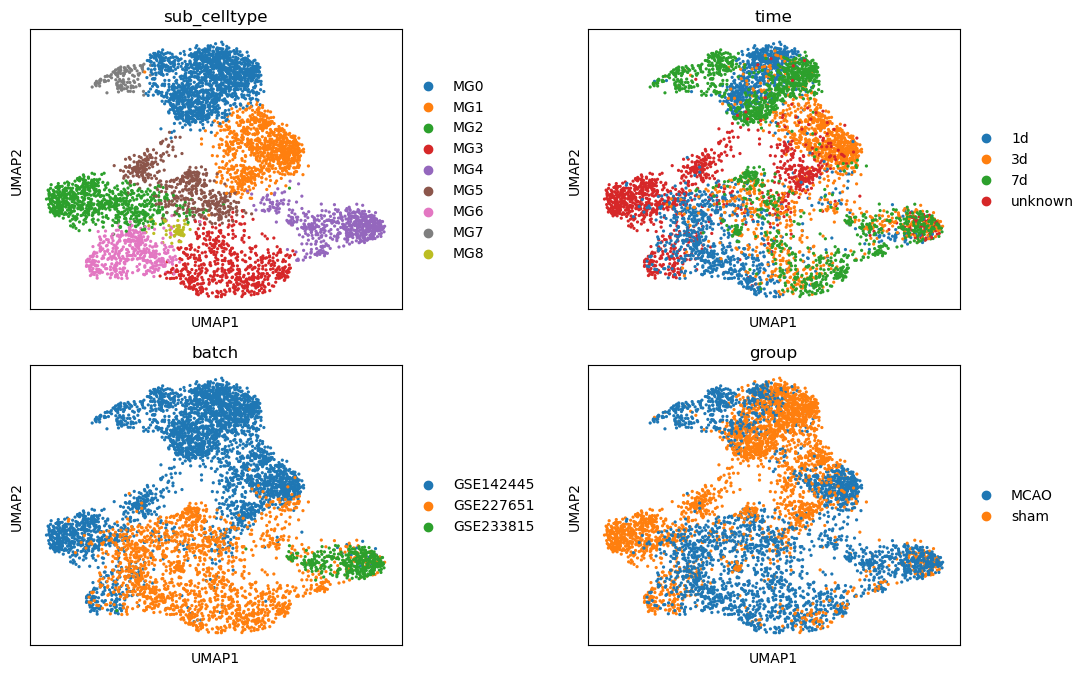

In [5]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os

display(os.getcwd())
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3
chosen_celltype = config["chosen_ct"]

import warnings
warnings.filterwarnings('ignore')

adata = sc.read(f"data/{config['project_code']}_{chosen_celltype}_cluster.h5ad")
# 去掉第5群,这一群分化情况有点过于鹤立鸡群
adata = adata[adata.obs.loc[:, "sub_celltype"] != 'MG9']

fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={"wspace": 0.5})
axes_flat = axes.flatten()
# 使用展平后的 axes_flat 数组中的 Axes 对象
sc.pl.umap(adata, color="sub_celltype", show=False, ax=axes_flat[0])
sc.pl.umap(adata, color="time", show=False, ax=axes_flat[1])
sc.pl.umap(adata, color="batch", show=False, cmap="Pastel1", ax=axes_flat[2])
sc.pl.umap(adata, color="group", show=False, ax=axes_flat[3])
fig.show()

## 处理手段、亚群归属、细胞周期柱状图

In [7]:
%reset -f
import numpy as np
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os

display(os.getcwd())
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3
chosen_celltype = config["chosen_ct"]

import warnings
warnings.filterwarnings('ignore')

adata = sc.read(f"data/{config['project_code']}_{chosen_celltype}_cluster.h5ad")
# 去掉第5群,这一群分化情况有点过于鹤立鸡群
adata = adata[adata.obs.loc[:, "sub_celltype"] != 'MG9']

'/Volumes/MacPassport/project/bioinformatics_project/sn_sc_intergration'

### 不同处理手段下亚群分布

<Figure size 1000x600 with 0 Axes>

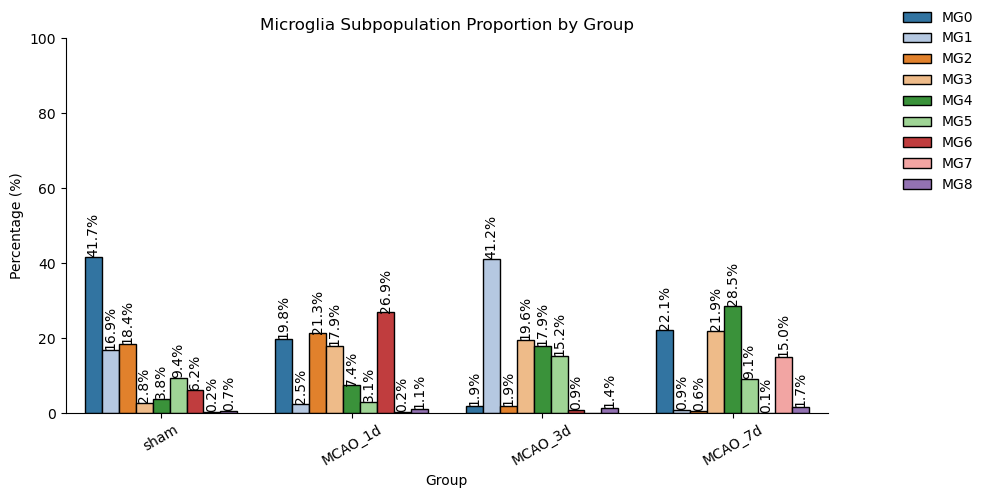

In [8]:
import seaborn as sns

# 1. 数据处理
# 将 adata.obs 转换为 DataFrame
obs_df = adata.obs.copy()

# 按 sub_celltype_condition 和 cluster 计数
cluster_counts = obs_df.groupby(['condition', "sub_celltype"]).size().reset_index(name='counts')

# 计算每个 condition 下的总细胞数
total_counts = obs_df.groupby('condition').size().reset_index(name='total')

# 合并计数数据并计算百分比占比
cluster_prop = cluster_counts.merge(total_counts, on='condition')
cluster_prop['proportion'] = cluster_prop['counts'] / cluster_prop['total'] * 100  # 转换为百分比

# 2. 绘制堆积百分比柱状图
plt.figure(figsize=(10, 6))

# 使用 seaborn 的 catplot，指定自定义顺序并获取图表对象
g = sns.catplot(
    data=cluster_prop,
    x='condition',
    y='proportion',
    hue="sub_celltype",
    kind='bar',
    height=5,
    aspect=1.5,
    palette='tab20',
    edgecolor='black',
    order=['sham', 'MCAO_1d', 'MCAO_3d', 'MCAO_7d']  # 自定义 x 轴顺序
)

# 设置标题和标签
plt.title('Microglia Subpopulation Proportion by Group')
plt.xlabel('Group')
plt.ylabel('Percentage (%)')

# 调整 x 轴标签（旋转45度以避免重叠）
plt.xticks(rotation=30)

# 确保 y 轴范围为 0-100
plt.ylim(0, 100)

# 添加百分比标签到柱体顶端
for ax in plt.gcf().axes:  # 遍历当前图表中的所有子图轴 (axes)，因为 catplot 可能生成多个子图
    for p in ax.patches:  # 遍历当前轴中的所有柱状图 patch 对象，每个 patch 代表一个柱体
        height = p.get_height()  # 获取当前柱体的垂直高度（即该亚群的百分比值）
        if height > 0:  # 仅对高度大于 0 的柱体添加标签，避免空柱体产生错误
            ax.text(
                p.get_x() + p.get_width() / 2.,  # 计算文本的 x 坐标：柱体左边缘位置 (get_x()) 加上柱体宽度的一半 (get_width() / 2)，实现水平居中
                p.get_y() + height,  # 计算文本的 y 坐标：柱体底部位置 (get_y()) 加上柱体高度 (height)，将标签置于柱体顶端
                f'{height:.1f}%',  # 设置文本内容：将 height 格式化为小数点后一位的百分比字符串（如 "12.3%"）
                ha="center",  # 水平对齐方式设为 "center"，确保文本在 x 坐标处居中
                va="bottom",  # 垂直对齐方式设为 "bottom"，确保文本底部与指定 y 坐标对齐（即贴在柱体顶部）
                rotation=90  # 旋转标签 90 度，使其垂直显示
            )

# 仅在主图表上添加图例，移动到右上角
g.legend.set_bbox_to_anchor((1.05, 1))  # 使用 catplot 的图例方法
g.legend.set_loc('upper left')  # 设置图例位置
g.legend.set_title('')  # 可选：移除图例标题以简化

# 调整布局
plt.tight_layout()

# 3. 保存图表
plt.savefig('figures/microglia_barplot_by_group.png', dpi=300, bbox_inches='tight')
plt.show()

### 不同亚群下处理手段分布

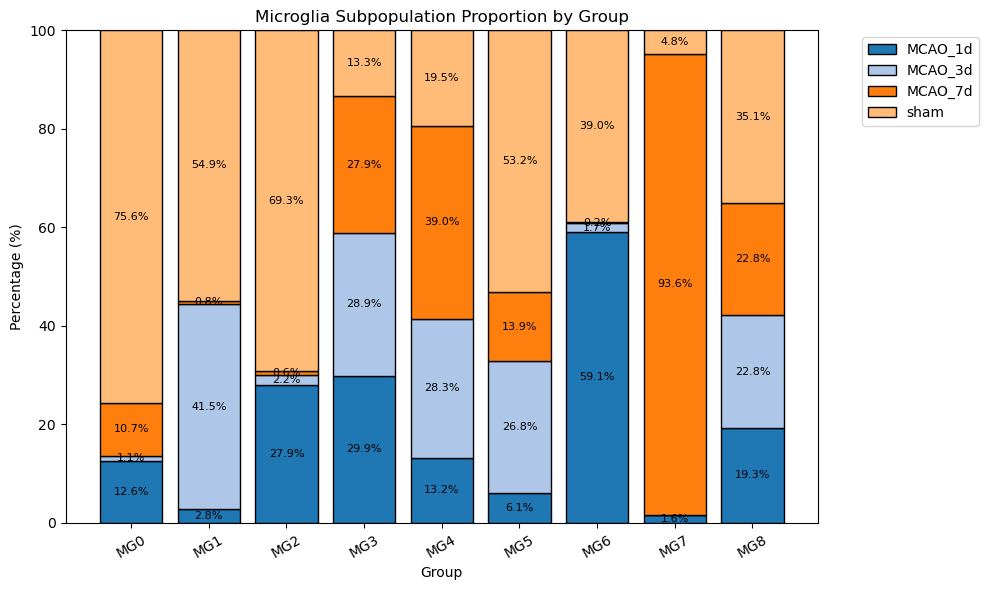

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. 将 adata.obs 转换为 DataFrame
obs_df = adata.obs.copy()

# 2. 数据处理
# 按 sub_celltype 和 condition 计数
cluster_counts = obs_df.groupby(['sub_celltype', 'condition']).size().reset_index(name='counts')

# 计算每个 sub_celltype 下的总细胞数
total_counts = obs_df.groupby('sub_celltype').size().reset_index(name='total')

# 合并计数数据并计算百分比占比
cluster_prop = cluster_counts.merge(total_counts, on='sub_celltype')
cluster_prop['proportion'] = cluster_prop['counts'] / cluster_prop['total'] * 100

# 3. 绘制堆积百分比柱状图
plt.figure(figsize=(10, 6))

# 使用 seaborn 的 barplot 实现堆积效果
# 先将数据转换为宽格式（pivot table）
pivot_df = cluster_prop.pivot(index='sub_celltype', columns='condition', values='proportion').fillna(0)
# pivot_df = pivot_df.loc[['sham', 'MCAO_1d', 'MCAO_3d', 'MCAO_7d']]  # 确保顺序
pivot_df.to_csv("result/Microglia Subpopulation Proportion by Group.tsv", sep="\t")

# 绘制堆积柱状图
bottom = np.zeros(len(pivot_df))  # 用于跟踪每根柱子的底部位置
colors = sns.color_palette('tab20', n_colors=len(pivot_df.columns))  # 使用 tab20 调色板

for idx, celltype in enumerate(pivot_df.columns):
    plt.bar(
        pivot_df.index,
        pivot_df[celltype],
        bottom=bottom,
        color=colors[idx],
        edgecolor='black',
        label=celltype
    )
    # 更新底部位置
    bottom += pivot_df[celltype].values

    # 添加百分比标签
    for i, (cond, prop) in enumerate(pivot_df[celltype].items()):
        if prop > 0:  # 仅对非零值添加标签
            plt.text(
                i,
                bottom[i] - prop/2,  # 标签位于当前段的中间
                f'{prop:.1f}%',
                ha='center',
                va='center',
                rotation=0,
                fontsize=8
            )

# 4. 设置图表属性
plt.title('Microglia Subpopulation Proportion by Group')
plt.xlabel('Group')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)
plt.xticks(rotation=30)

# 添加图例
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='')

# 调整布局
plt.tight_layout()

# 5. 保存图表
# plt.savefig('figures/microglia_stacked_barplot.png', dpi=300, bbox_inches='tight')
plt.show()

# 即兴分析

In [14]:
%reset -f
import scanpy as sc
import yaml, os
display(os.getcwd())
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
sc.settings.verbosity = 3
chosen_celltype = config["chosen_ct"]
# 加载数据
adata_mg = sc.read(f"data/{config['project_code']}_{chosen_celltype}_cluster.h5ad")
adata_all = sc.read(f"data/{config['project_code']}_cluster.h5ad")

'/Volumes/MacPassport/project/bioinformatics_project/sn_sc_intergration'

In [15]:
import pandas as pd

# Load the two dataframes
df_microglia = pd.read_csv('result/deg_by_major_celltype/deg_of_Microglia.tsv', sep='\t')
df_mg3 = pd.read_csv('result/deg_by_Microglia_subcluster/deg_of_MG3.tsv', sep='\t')

# Get the set of gene names from the Microglia table for efficient lookup
microglia_genes = set(df_microglia['names'])

# Filter the MG3 dataframe, keeping only the rows where the gene name is in the microglia_genes set
filtered_mg3_df = df_mg3[df_mg3['names'].isin(microglia_genes)]

# Save the filtered dataframe to a new TSV file
# filtered_mg3_df.to_csv('filtered_deg_of_MG3.tsv', sep='\t', index=False)

# Print the number of genes in the filtered dataframe and display the first few rows
print(f"The filtered MG3 table contains {len(filtered_mg3_df)} genes.")
print("Here are the first few rows of the filtered table:")
print(filtered_mg3_df.head().to_string())

The filtered MG3 table contains 159 genes.
Here are the first few rows of the filtered table:
   names     scores         pvals     pvals_adj  log2foldchanges  diff.pct
2  Fxyd1  -2.373840  1.760416e-02  4.715400e-02        -2.482678  0.663728
3  Fcgrt  11.951410  6.383304e-33  1.556903e-31         1.171584  0.588089
4   Flt1   3.638522  2.742068e-04  1.170157e-03         1.315195  0.563761
7    Vwf   2.059833  3.941449e-02  9.414288e-02         1.543184  0.491171
9  Nat8l  -2.075946  3.789897e-02  9.095754e-02        -2.594272  0.434177


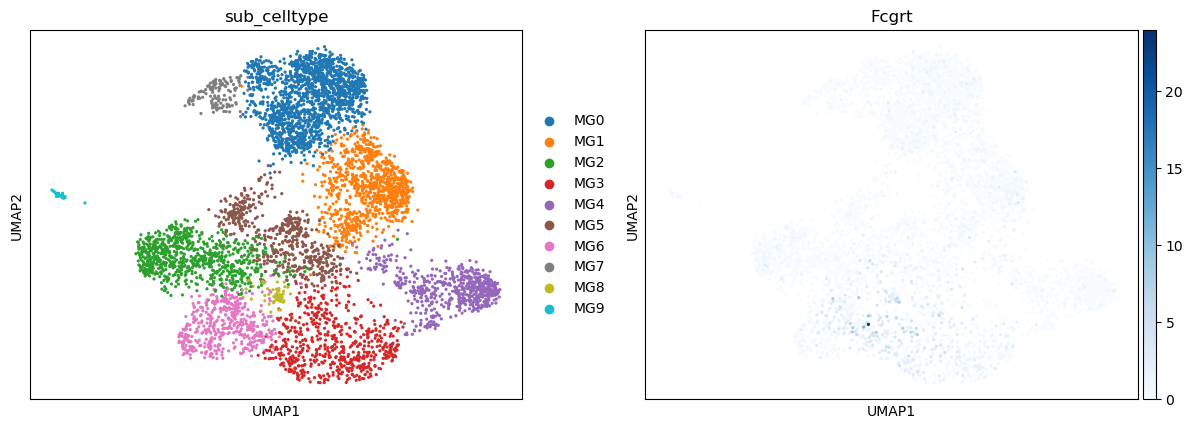

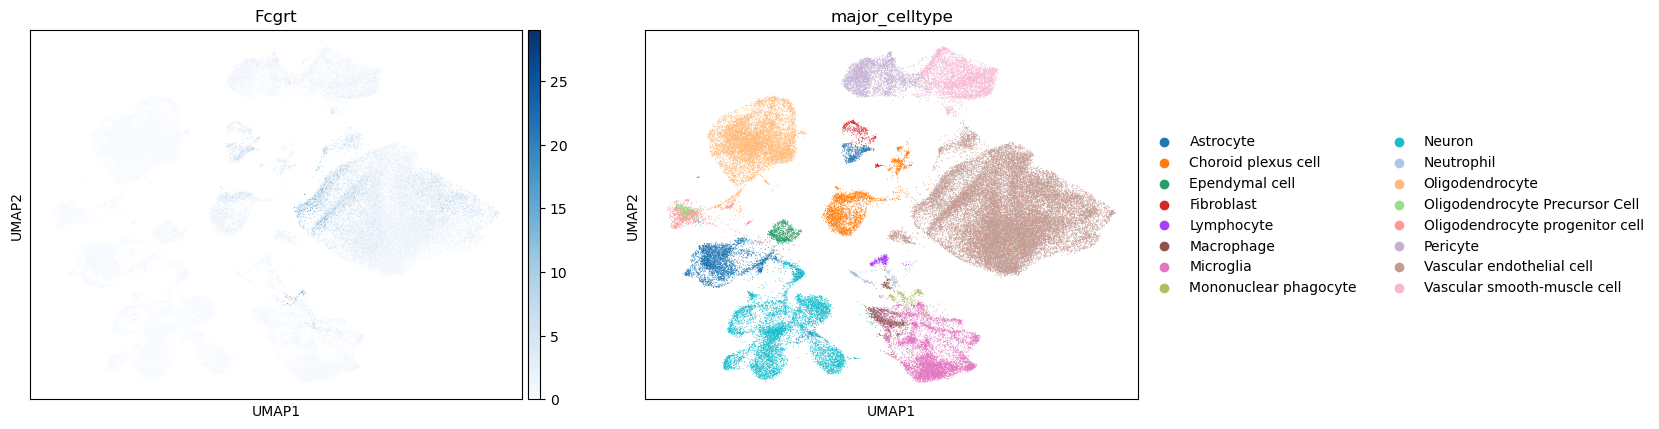

In [16]:
sc.pl.umap(adata_mg, color=["sub_celltype", "Fcgrt"], cmap="Blues")
sc.pl.umap(adata_all, color=["Fcgrt", "major_celltype"], cmap="Blues")